# Load in the full Dataset from the ESO archive

In [4]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_fwf("Dataset_full.txt" , engine='python', encoding='utf-8-sig')

In [5]:
#Only keep the OBJECT data from the Irdis module
df = df.loc[df['TPL ID'] == "SPHERE_irdis_dpi_obs"]
df_mod = df.loc[df['Type'] == "OBJECT"]

#Rename the Mode column to Coronography, rename values
df_mod = df_mod.rename(columns = {'Mode': 'Coronography'})
df_mod.loc[df_mod['Coronography'] == 'POLARIMETRY', 'Coronography'] = '-'
df_mod.loc[df_mod['Coronography'] == 'POLARIMETRY,CORONOGRAPHY', 'Coronography'] = 'Coronography'

#Log the observation date
obs_date = df_mod['Dataset_ID'].str[6:16]
df_mod['Observation_Date'] = obs_date

#Show necessary columns
df_mod = df_mod[['OBJECT', 'RA', 'DEC', 'Observation_Date', 'Program_ID', 'Coronography', 'Filter', 'DIMM_Seeing_at_Start']]

In [6]:
#Get indexes where there are values we don't want
indexNames = df_mod[df_mod['Coronography'] == 'POLARIMETRY,SAM'].index #unwanted modes
seeing = df_mod[df_mod['DIMM_Seeing_at_Start'] == '-1.00'].index #incorrect values
ROXS = df_mod[df_mod['OBJECT'] == 'ROXS 42'].index #Gives 3 instead of 1 options in Simbad

#Delete these row indexes with bad values from DataFrame
df_mod.drop(indexNames , inplace=True)
df_mod.drop(seeing , inplace=True)
df_mod.drop(ROXS , inplace=True)
df_mod = df_mod.dropna(subset=['DEC', 'DIMM_Seeing_at_Start'])

#Reset the index and show the modified dataset
df_mod.reset_index(drop=True, inplace=True)

# 1 Calculate the mean DIMM per date

In [7]:
#Calculate the average DIMM seeing at start for each date
df_DIMM = df_mod
df_DIMM.sort_values("Observation_Date", inplace = True)
df_DIMM['DIMM_Seeing_at_Start'] = df_DIMM['DIMM_Seeing_at_Start'].astype(float, errors = 'raise')
df_DIMM.reset_index(drop=True, inplace=True)

mean = df_DIMM.groupby(['Observation_Date']).mean()
#mean

array([[<AxesSubplot:title={'center':'DIMM_Seeing_at_Start'}>]],
      dtype=object)

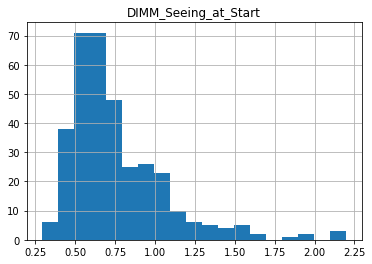

In [9]:
#plot the mean distribution in a histogram
mean['DIMM_Seeing_at_Start'] = mean['DIMM_Seeing_at_Start'].astype(float, errors = 'raise')
mean.hist(bins='sqrt')

In [10]:
#Replace DataFrame values with average values for each date
for i in range(0,len(df_DIMM)):
    for j in range(0,len(mean)):
        if df_DIMM.iloc[i,3] == str(mean.index[j]):
            df_DIMM.iloc[i,7] = round(float(mean.iloc[j,0]),2)
            
df_DIMM.head()

,OBJECT,RA,DEC,Observation_Date,Program_ID,Coronography,Filter,DIMM_Seeing_at_Start
0,MWC 758,05:30:27.67,+25:19:53.8,2014-12-06,60.A-9389(A),Coronography,B_Y,1.15
1,MWC 758,05:30:27.67,+25:19:53.8,2014-12-06,60.A-9389(A),Coronography,B_Y,1.15
2,MWC 758,05:30:27.67,+25:19:53.8,2014-12-06,60.A-9389(A),Coronography,B_Y,1.15
3,MWC 758,05:30:27.67,+25:19:53.8,2014-12-06,60.A-9389(A),Coronography,B_Y,1.15
4,MWC 758,05:30:27.67,+25:19:53.8,2014-12-06,60.A-9389(A),Coronography,B_Y,1.15


In [11]:
#Dropping duplicates for average DIMM to reduce the length of the DataFrame
df_DIMM = df_DIMM.rename(columns = {'DIMM_Seeing_at_Start': 'Average_DIMM'})
df_single = df_DIMM.drop_duplicates(subset=['RA', 'DEC', 'Coronography', 'Filter', 'Average_DIMM', 'Observation_Date', 'Program_ID'], keep='first')
df_single.sort_values(['RA', 'DEC', 'Observation_Date'], inplace = True)
df_single.reset_index(drop=True, inplace=True)

# 2 Fix Coordinates

In [12]:
df_try = df_single

#The viewfinder is 12x12 arcseconds, we use a margin of error or 10 arcseconds
margin = 10*(1/3600) #in degrees

## 2.1 Convert RA and DEC to degrees

In [13]:
#Convert RA to degrees
RA_hour = list(df_try['RA'].str[:2])
RA_minute = list(df_try['RA'].str[3:5])
RA_seconds = list(df_try['RA'].str[6:11])
RA_converted = []

for i in range (0,len(RA_hour)):
    RA_hour[i] = float(RA_hour[i])*15
    RA_minute[i] = float(RA_minute[i])*0.25
    RA_seconds[i] = float(RA_seconds[i])*(15/3600)
    
    degrees = RA_hour[i] + RA_minute[i] + RA_seconds[i]
    RA_converted.append(degrees)
    
#RA_converted

#Use the margin of error 
RA_error_min = []
RA_error_plus = []

for i in range(0,len(RA_converted)):
    RA_error_plus.append(RA_converted[i] + margin) 
    RA_error_min.append(RA_converted[i] - margin)
    
#RA_error_min, RA_error_plus

In [14]:
#Convert DEC to degrees
DEC_degrees = list(df_try['DEC'].str[0:3])
DEC_arcmin = list(df_try['DEC'].str[4:6])
DEC_arcsec = list(df_try['DEC'].str[7:12])
DEC_converted = []

for i in range (0,len(DEC_degrees)):
    DEC_degrees[i] = float(DEC_degrees[i])
    DEC_arcmin[i] = float(DEC_arcmin[i])*(1/60)
    DEC_arcsec[i] = float(DEC_arcsec[i])*(1/3600)
    
    degrees = DEC_degrees[i] + DEC_arcmin[i] + DEC_arcsec[i] +90
    DEC_converted.append(degrees)

#DEC_converted

#Now calculate the margin of error
DEC_error_min = []
DEC_error_plus = []

for i in range(0,len(DEC_converted)):
    DEC_error_min.append(DEC_converted[i] - margin)
    DEC_error_plus.append(DEC_converted[i] + margin)
    
#DEC_error_min, DEC_error_plus

## 2.2 Matching same coordinates and names

In [15]:
#loop through the coordinates to see wheter they fall within eachothers error margins

for i in range(1, len(df_try)):
    ra = RA_converted[i]
    ra_margin_plus = RA_error_plus[i-1]
    ra_margin_min = RA_error_min[i-1]
    
    #Check if they are the same RA, within error
    if ra < ra_margin_plus and ra > ra_margin_min:
        df_try.iloc[i,1] = str(df_try.iloc[i-1,1])
        
    dec = DEC_converted[i]
    dec_margin_plus = DEC_error_plus[i-1]
    dec_margin_min = DEC_error_min[i-1]
    
    #Do the same for DEC within error
    if dec < dec_margin_plus and dec > dec_margin_min:
        df_try.iloc[i,2] = str(df_try.iloc[i-1,2])

#Now the coordinates are matched

In [16]:
#Match the object names in the same way the RA and DEC was matched
for i in range(1,len(df_try)):
    if (df_try.iloc[i,2] == str(df_try.iloc[i-1,2])) and (df_try.iloc[i,1] == str(df_try.iloc[i-1,1])):
        df_try.iloc[i,0] = str(df_try.iloc[i-1,0])
        
#Now the names are matched to the coordinates
df_try.head()

,OBJECT,RA,DEC,Observation_Date,Program_ID,Coronography,Filter,Average_DIMM
0,HD377,00:08:25.90,+06:37:01.1,2018-08-16,0101.C-0128(B,Coronography,B_H,0.60
1,2MASS J00172353-664512,00:17:23.89,-66:45:13.0,2019-10-22,0104.C-0675(A,Coronography,B_H,0.49
2,2MASS J00172353-664512,00:17:23.89,-66:45:13.0,2019-11-06,0104.C-0675(A,Coronography,B_H,0.60
3,47 TUCAN,00:23:57.21,-72:05:26.3,2016-09-20,60.A-9800(S),-,B_H,0.93
4,HD 4747,00:49:27.46,-23:12:43.1,2018-09-10,0101.C-0635(A,Coronography,B_KS,1.32


In [18]:
#Again drop the duplicates for the same objects but with slightly different coordinates
df_single2 = df_try.drop_duplicates(subset=['RA', 'DEC', 'Coronography', 'Filter', 'Average_DIMM', 'Observation_Date'], keep='first')
df_single2.reset_index(drop=True, inplace=True)
        
#around 700 datapoints remain

## 2.3 Find individual coordinates

In [19]:
#We only need the coordinates for every individual object for the next phase
df_coords = df_single2.drop_duplicates(subset=['RA', 'DEC'], keep='first')
df_coords.reset_index(drop=True, inplace=True)
df_coords.sort_values(['RA', 'DEC'], inplace = True)
df_coords = df_coords[['OBJECT', 'RA', 'DEC']]

RA_normal = list(df_coords['RA'])
DEC_normal = list(df_coords['DEC'])

#The two cells beneath this could be taken from previous work?
df_coords.head()

,OBJECT,RA,DEC
0,HD377,00:08:25.90,+06:37:01.1
1,2MASS J00172353-664512,00:17:23.89,-66:45:13.0
2,47 TUCAN,00:23:57.21,-72:05:26.3
3,HD 4747,00:49:27.46,-23:12:43.1
4,V RZ PSC,01:09:42.02,+27:56:59.8


In [20]:
#Convert RA to degrees
RA_hour_coords = list(df_coords['RA'].str[:2])
RA_minute_coords = list(df_coords['RA'].str[3:5])
RA_seconds_coords = list(df_coords['RA'].str[6:11])
RA_converted_coords = []

for i in range (0,len(RA_hour_coords)):
    RA_hour_coords[i] = float(RA_hour_coords[i])*15
    RA_minute_coords[i] = float(RA_minute_coords[i])*0.25
    RA_seconds_coords[i] = float(RA_seconds_coords[i])*(15/3600)
    
    degrees = RA_hour_coords[i] + RA_minute_coords[i] + RA_seconds_coords[i]
    RA_converted_coords.append(degrees)
    
#RA_converted_coords

In [21]:
#Convert DEC to degrees
DEC_degrees_coords = list(df_coords['DEC'].str[0:3])
DEC_arcmin_coords = list(df_coords['DEC'].str[4:6])
DEC_arcsec_coords = list(df_coords['DEC'].str[7:12])
DEC_converted_coords = []

for i in range (0,len(DEC_degrees_coords)):
    DEC_degrees_coords[i] = float(DEC_degrees_coords[i])
    DEC_arcmin_coords[i] = float(DEC_arcmin_coords[i])*(1/60)
    DEC_arcsec_coords[i] = float(DEC_arcsec_coords[i])*(1/3600)
    
    degrees = DEC_degrees_coords[i] + DEC_arcmin_coords[i] + DEC_arcsec_coords[i]
    DEC_converted_coords.append(degrees)

#DEC_converted_coords

In [22]:
#Add the converted coords to a new dataframe with the object names and original coordinates
names = df_coords['OBJECT']
df_query = pd.DataFrame(list(zip(names, RA_converted_coords, DEC_converted_coords, RA_normal, DEC_normal)),
               columns =['OBJECT', 'RA_deg', 'DEC_deg', 'RA', 'DEC'])

df_query.head()

,OBJECT,RA_deg,DEC_deg,RA,DEC
0,HD377,2.107917,6.616972,00:08:25.90,+06:37:01.1
1,2MASS J00172353-664512,4.349542,-65.246389,00:17:23.89,-66:45:13.0
2,47 TUCAN,5.988375,-71.909361,00:23:57.21,-72:05:26.3
3,HD 4747,12.364417,-22.788028,00:49:27.46,-23:12:43.1
4,V RZ PSC,17.425083,27.949944,01:09:42.02,+27:56:59.8


# 3 Automized Simbad Query

In [23]:
import os
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Simbad.ROW_LIMIT = 10

In [24]:
df = df_query

#add the Object and coordinates to lists
name_query = list(df['OBJECT'])
ra_query = list(df['RA_deg'])
dec_query = list(df['DEC_deg'])

## 3.1 Run through the search query

In [25]:
#go through the catalogue list to check the object_types
target_names = []
object_types = []
sec_otypes = []
simbad_ra = []
simbad_dec = []

for i in range(0,len(df)): 
    
    #Check for Difficult names and change them
    if (name_query[i][0] == "V") and (name_query[i][1] == " "):
        name_query[i] = name_query[i][2:]
        
    #If the Object name does not have a match in Simbad, search by RA and DEC
    if Simbad.query_object(name_query[i]) == None:
        
        c = SkyCoord(ra=ra_query[i]*u.degree, dec=dec_query[i]*u.degree, frame='icrs')
        r = (1000*(1/3600)) * u.degree #search region
        result_table = Simbad.query_region(c,radius= r)[0]

        mytarget_name = result_table["MAIN_ID"]
        target_names.append(mytarget_name)
    
        customSimbad = Simbad()
    
        customSimbad.add_votable_fields("otype")
        customSimbad.add_votable_fields("otypes")
        result = customSimbad.query_object(mytarget_name)
        otype = result["OTYPE"]
        otypes = result["OTYPES"]
        sim_ra = result["RA"]
        sim_dec = result["DEC"]
    
        object_types.append(otype)
        sec_otypes.append(otypes)
        simbad_ra.append(sim_ra)
        simbad_dec.append(sim_dec)
    
    #If the name does match, save the identities
    else:
        target_names.append(name_query[i])
        customSimbad = Simbad()
        customSimbad.add_votable_fields("otype")
        customSimbad.add_votable_fields("otypes")
        result = customSimbad.query_object(name_query[i])
        otype = result["OTYPE"]
        otypes = result["OTYPES"]
        sim_ra = result["RA"]
        sim_dec = result["DEC"]
        
        object_types.append(otype)
        sec_otypes.append(otypes)
        simbad_ra.append(sim_ra)
        simbad_dec.append(sim_dec)
        
#ignore the error messages this code gives, some object names do not return a query

C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '2MASS J00172353-664512' this identifier has an incorrect format for catalog: 	2MASS : 2 Micron Sky Survey, Point Sources
  (error.line, error.msg))
C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '2MASS J02014693+011705' this identifier has an incorrect format for catalog: 	2MASS : 2 Micron Sky Survey, Point Sources
  (error.line, error.msg))
C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '46P': No known catalog could be found
  (error.line, error.msg))
C:\Users\Gebruiker\Anaconda3\lib\site-p

C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '2MASS J16102857-190446' this identifier has an incorrect format for catalog: 	2MASS : 2 Micron Sky Survey, Point Sources
  (error.line, error.msg))
C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '2MASS J16111534-175721' this identifier has an incorrect format for catalog: 	2MASS : 2 Micron Sky Survey, Point Sources
  (error.line, error.msg))
C:\Users\Gebruiker\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 4 raised an error (recorded in the `errors` attribute of the result table): '2MASS J16141107-230536' this identifier has an incorrect format for catalog: 	2MASS : 2 Micron Sky Surve

In [26]:
#get the Data from the masked column value for the secondary object types and rewrite to string

#convert masked column to strings
for i in range(0,len(sec_otypes)):
    sec_otypes[i] = str(sec_otypes[i].data)[2:-2]
    sec_otypes[i] = sec_otypes[i].replace("|", "/")
    
    object_types[i] = str(object_types[i].data)[2:-2]
    simbad_ra[i] = str(simbad_ra[i].data)[2:-2]
    simbad_ra[i] = simbad_ra[i].replace(" ", ":")
    simbad_dec[i] = str(simbad_dec[i].data)[2:-2]
    simbad_dec[i] = simbad_dec[i].replace(" ", ":")

In [27]:
#Combine the gathered data into a new dataframe
df['O_Type'] = object_types
df['secondary_types'] = sec_otypes
df['Simbad_ID'] = target_names
df['RA_simbad'] = simbad_ra
df['DEC_simbad'] = simbad_dec

df_simbad = df[['OBJECT', 'Simbad_ID', 'RA', 'RA_simbad', 'DEC', 'DEC_simbad', 'O_Type', 'secondary_types']]
df_simbad.head()

,OBJECT,Simbad_ID,RA,RA_simbad,DEC,DEC_simbad,O_Type,secondary_types
0,HD377,HD377,00:08:25.90,00:08:25.7456,+06:37:01.1,+06:37:00.488,PM*,*/PM*/V*/IR/X
1,2MASS J00172353-664512,GALEX 2676521368638459328,00:17:23.89,00:17:35.5093,-66:45:13.0,-65:11:39.796,Blue,*/blu/UV
2,47 TUCAN,47 TUCAN,00:23:57.21,00:24:05.359,-72:05:26.3,-72:04:53.20,GlCl,UV/X/gam/Cl*/GlC/GlC/OpC/*/G/IR
3,HD 4747,HD 4747,00:49:27.46,00:49:26.7612,-23:12:43.1,-23:12:44.865,SB*,**/SB*/PM*/PM*/PM*/IR/X/SB*/*
4,V RZ PSC,RZ PSC,01:09:42.02,01:09:42.0523,+27:56:59.8,+27:57:01.912,Ae*,*/Ae*/V*/IR


# 3.2 Keeping the Young Stars

In [43]:
#Reduce the Dataframe to only keep the Young Star Object Types
final_df = df_simbad.loc[df_simbad['O_Type'].str.contains("Y*O|Ae*|Em*|TT*|Or*", case=True)]
final_df.reset_index(drop=True, inplace=True)

In [44]:
df1 = df_single2
df2 = final_df

In [45]:
#Add the Simbad_ID from df2 to df1
df1['Simbad_ID'] = ""
df1 = df1[['OBJECT','Simbad_ID', 'RA', 'DEC', 'Program_ID', 'Observation_Date', 'Coronography', 'Filter', 'Average_DIMM']]

for i in range(0,len(df1)):
    for j in range(0,len(df2)):
        if df1.iloc[i,0] == str(df2.iloc[j,0]):
            df1.iloc[i,1] = str(df2.iloc[j,1])


In [46]:
#Only keep the necesarry columns
df2 = df2.drop(['RA_simbad','DEC_simbad', 'secondary_types', 'O_Type'], axis=1)
df2.sort_values("RA", inplace = True)
df2.reset_index(drop=True, inplace=True)

In [47]:
#only keep datapoints in df1 that are in df2
keys = list(df2.columns.values)
i1 = df1.set_index(keys).index
i2 = df2.set_index(keys).index
df1 = df1[i1.isin(i2)]
df1.reset_index(drop=True, inplace=True)

## 3.3 Save the final DataFrame as the Catalogue

In [48]:
df1.sort_values(['RA', 'DEC', 'Observation_Date', 'Filter'], inplace = True)
df1.reset_index(drop=True, inplace=True)
df1.to_csv('YoungStars_Catalogue.txt', sep=';', index=False)

# 4 Write DataFrame as a MultiIndex

In [54]:
#Showing the final DataFrame in a MultiIndex
show = pd.MultiIndex.from_frame(df1)
Catalogue = pd.Series(index=show)
Catalogue = pd.DataFrame(Catalogue)
Catalogue = Catalogue.iloc[: , :-1]
Catalogue

Empty DataFrame
Columns: []
Index: [(V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0101.C-0635(A, 2018-10-01, Coronography, B_H, 0.79), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-16, -, B_H, 0.42), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-17, -, B_KS, 0.57), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-17, Coronography, B_KS, 0.57), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-19, Coronography, B_KS, 0.5), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-21, Coronography, B_KS, 0.29), (V RZ PSC, RZ PSC, 01:09:42.02, +27:56:59.8, 0103.C-0384(A, 2019-08-23, Coronography, B_KS, 0.72), (V BX ARI, BX ARI, 02:58:11.19, +20:30:01.6, 0101.C-0060(A, 2018-10-01, Coronography, B_H, 0.79), (LKHA_330, LKHA_330, 03:45:48.01, +32:24:09.9, 098.C-0760(B), 2017-10-06, Coronography, B_J, 0.55), (LKHA_330, LKHA_330, 03:45:48.01, +32:24:09.9, 0100.C-0452(A, 2017-10-07, Coronography, B_H, 0.75), (LKHA_330, LKHA_330, 03:45:48.01, +32:24:09.9, 0100.C-0452(A, 2017-10-12, Coronography, B_H, 0.71), (LKHA_330, LKHA_330, 03:45:48.01, +32:24:09.9, 098.C-0760(B), 2017-12-06, -, B_H, 0.84), (LKHA_330, LKHA_330, 03:45:48.01, +32:24:09.9, 106.21HJ.001, 2020-12-08, Coronography, B_KS,P0-90, 0.47), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2018-12-23, Coronography, B_H, 0.61), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2018-12-23, -, B_H, 0.61), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2019-10-23, Coronography, B_H, 0.89), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2019-10-23, -, B_H, 0.89), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2019-11-02, -, B_H, 0.73), (V CW TAU, CW TAU, 04:14:16.92, +28:10:53.4, 0102.C-0453(A, 2019-11-02, Coronography, B_H, 0.73), (V FP TAU, FP TAU, 04:14:47.05, +26:46:26.9, 0102.C-0453(A, 2019-08-29, Coronography, B_H, 0.72), (V FP TAU, FP TAU, 04:14:47.05, +26:46:26.9, 0102.C-0453(A, 2019-10-24, -, B_H, 0.33), (V FP TAU, FP TAU, 04:14:47.05, +26:46:26.9, 0102.C-0453(A, 2019-10-24, Coronography, B_H, 0.33), (V CX TAU, CX TAU, 04:14:47.05, +26:48:11.2, 0102.C-0453(A, 2019-08-07, Coronography, B_H, 0.54), (V CX TAU, CX TAU, 04:14:47.05, +26:48:11.2, 0102.C-0453(A, 2019-08-07, -, B_H, 0.54), (V CX TAU, CX TAU, 04:14:47.05, +26:48:11.2, 0102.C-0453(A, 2019-10-24, -, B_H, 0.33), (V CX TAU, CX TAU, 04:14:47.05, +26:48:11.2, 0102.C-0453(A, 2019-10-24, Coronography, B_H, 0.33), (V409 TAU, V409 TAU, 04:18:10.91, +25:19:56.2, 1104.C-0415(A, 2019-11-17, Coronography, B_H, 0.82), (V409 TAU, V409 TAU, 04:18:10.91, +25:19:56.2, 0104.C-0850(A, 2019-11-24, Coronography, B_H, 0.88), (V BP TAU, BP TAU, 04:19:15.72, +29:06:27.4, 0102.C-0453(A, 2018-12-23, Coronography, B_H, 0.61), (V BP TAU, BP TAU, 04:19:15.72, +29:06:27.4, 0102.C-0453(A, 2018-12-23, -, B_H, 0.61), (V DE TAU, DE TAU, 04:21:55.53, +27:55:05.6, 0102.C-0453(A, 2019-10-22, Coronography, B_H, 0.49), (V DE TAU, DE TAU, 04:21:55.53, +27:55:05.6, 0102.C-0453(A, 2019-10-22, -, B_H, 0.49), (V RY TAU, RY TAU, 04:21:57.68, +28:26:39.3, 1104.C-0415(E, 2019-12-17, Coronography, B_H, 0.77), (T TAU N, T TAU N, 04:21:59.20, +19:32:04.0, 198.C-0209(N), 2016-11-19, Coronography, B_H, 0.66), (V IP TAU, IP TAU, 04:24:56.73, +27:11:57.2, 0104.C-0850(A, 2019-11-24, Coronography, B_H, 0.88), (V IP TAU, IP TAU, 04:24:56.73, +27:11:57.2, 1104.C-0415(A, 2019-12-15, Coronography, B_H, 0.58), (V DF TAU, DF TAU, 04:27:02.59, +25:42:23.5, 0102.C-0466(B, 2018-11-29, -, B_H, 0.93), (DH TAU, DH TAU, 04:29:41.30, +26:33:00.1, 0102.C-0916(A, 2019-08-17, Coronography, B_H, 0.57), (DH TAU, DH TAU, 04:29:41.30, +26:33:00.1, 0102.C-0916(A, 2019-09-16, Coronography, B_H, 1.04), (DH TAU, DH TAU, 04:29:41.30, +26:33:00.1, 0102.C-0916(A, 2019-10-24, Coronography, B_H, 0.33), (DH TAU, DH TAU, 04:29:41.30, +26:33:00.1, 0102.C-0916(A, 2019-10-25, Coronography, B_H, 0.58), (DH TAU, DH TAU, 04:29:41.30, +26:33:00.1, 0102.C-0916(A, 2019